In [1]:
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
import ast
import pickle as pkl
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

from scipy.stats import pearsonr as lincorr

from functools import partial

import sys
sys.path.append('/gpfs01/euler/User/lhoefling/GitHub/nnfabrik_euler')

In [3]:
from rgc_natstim_model.utils.inference import get_model_responses
from rgc_natstim_model.utils.data_handling import convert_nested_dict_to_dataframe

In [4]:
from rgc_natstim_model.analyses.eval import calculate_correlations, calculate_nat_reliability_index

In [5]:
from rgc_natstim_model.constants.plot_settings import cmap_colors

# Import constants

In [6]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids
from rgc_natstim_model.constants.paths import base_directory
print(base_directory)

/gpfs01/euler/data/SharedFiles/projects/Hoefling2024/


In [7]:
stim_path = os.path.join(base_directory, 'data', 'mei', 'experiment', 'mei_stimuli', 'standard')
print(stim_path)

/gpfs01/euler/data/SharedFiles/projects/Hoefling2024/data/mei/experiment/mei_stimuli/standard


# load experiment and stimulus metadata

In [8]:
date="2021-09-29"
exp_num=2
field_id=1
stim_exp_num = 3
stim_field_id = 1

In [9]:
idx2neuronid = np.load(os.path.join(
    stim_path, 
    "neuron_ids{date}_{stim_exp_num}_{stim_field_id}_standard.npy".format(
    date=''.join(date.split("-")), 
    stim_exp_num=stim_exp_num,
    stim_field_id=stim_field_id
    )
),
                       allow_pickle=True).item()

In [10]:
sequence = np.load(os.path.join(stim_path, 
                                "seq{date}_{stim_exp_num}_{stim_field_id}_standard.npy".format(
    date=''.join(date.split("-")), 
    stim_exp_num=stim_exp_num,
    stim_field_id=stim_field_id
)),
                   allow_pickle=True)



In [11]:
with open(os.path.join(stim_path, "type_to_neuronid.txt"), "r") as f:
    contents = f.read()
    type_to_nid = ast.literal_eval(contents)

In [12]:
with open(os.path.join(base_directory, 'data', 'mei',  'experiment', 'imaging', 'readout_dict_var_scaled.pkl'), "rb") as f:
    readout_dict_var_scaled = pkl.load(f)

In [13]:
with open(os.path.join(base_directory, 'data', 'mei', 'experiment', 'imaging', 'readout_dict_mean_scaled.pkl'), "rb") as f:
    readout_dict_mean_scaled = pkl.load(f)

# Load data from file

In [14]:
dataset_hash = '069836032a542cb20fe4c678dde07615'

In [15]:
data_filename = '2024-06-17_neuron_data_stim_c285329_responses_0698360_wri.h5'
responses = load_h5_into_dict(os.path.join(base_directory, 'data', 'base', data_filename))
movie_data_dict = {dataset_hash: make_final_responses(responses, response_type="natural")}

Loading HDF5 file contents:   0%|          | 0/385 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/11 [00:00<?, ?it/s]

In [16]:
df = convert_nested_dict_to_dataframe(movie_data_dict)

In [18]:
with open(os.path.join(base_directory, 'data', 'mei', 'experiment', 'imaging', 'mei_exp_validation_results.pkl'), 'rb') as f:
    mei_exp_validation_results_df = pd.read_pickle(f)

In [19]:
mei_exp_validation_results_df.set_index('neuron_id', drop=False, inplace=True)

In [20]:
full_df = pd.concat([df, mei_exp_validation_results_df], join='inner', axis=1)
full_df = full_df.loc[:, ~full_df.columns.duplicated()]

### quality filter DF

In [21]:
full_df['max_conf'] = full_df.apply(lambda row: row['group_confidences'][row['group_assignment']-1], axis=1)

In [22]:
full_df = full_df[full_df['max_conf'] >= .25]

In [23]:
full_df.shape

(788, 70)

In [24]:
example_types = [1, 5, 10, 18, 20, 21, 23, 24, 28, 31, 32]

In [25]:
for t in example_types:
    print("{}, min conf: {}".format(t, full_df[full_df["group_assignment"]==t]["max_conf"].min()), 
          len(full_df[full_df["group_assignment"]==t]))

1, min conf: 0.25 13
5, min conf: 0.44999998807907104 6
10, min conf: 0.25999999046325684 8
18, min conf: 0.27000001072883606 17
20, min conf: 0.2800000011920929 8
21, min conf: 0.27000001072883606 8
23, min conf: 0.2800000011920929 40
24, min conf: 0.6399999856948853 4
28, min conf: 0.25 12
31, min conf: 0.2800000011920929 55
32, min conf: 0.28999999165534973 54


In [26]:
example_types_df = pd.concat([full_df[full_df["group_assignment"]==t] for t in example_types],
                            join="inner", axis=0)
palette_example_types = [cmap_colors[t-1] for t in example_types]

# make plots

### plot settings

In [27]:
rc_dict_resp = {'figure.dpi': 300,
 'figure.figsize': [2, 1],
 'figure.frameon': False,
 'font.size': 8,
                'lines.linewidth':1, 
 'lines.markersize': 2,
 'lines.markeredgewidth': 0.5,
 'legend.columnspacing': 0.5,
 'legend.frameon': False,
 'legend.markerscale': 0.4,
 'legend.labelspacing': 0.1,
 'legend.handletextpad': 0,
 'legend.loc': 'lower right',
 'axes.labelpad': 1.0,
 'xtick.major.pad': 1,
 'ytick.major.pad': 1}

# define constants

In [28]:
from collections import OrderedDict

In [29]:
ordered_type_to_nid = OrderedDict([(1, '20201030_1_3_65_s_5'),
             (5, '20201117_2_3_24_s_5'),
             (10, '20201117_2_2_96_s_5'),
             (18, '20201117_2_3_82_s_5'),
             (20, '20201022_2_4_12_s_5'),
             (21, '20201030_1_1_90_s_5'),
             (23, '20201022_2_2_87_s_5'),
             (24, '20201022_2_3_57_s_5'),
             (28, '20201022_2_4_13_s_5'),
             (31, '20201022_2_3_45_s_5'),
             (32, '20201021_1_2_18_s_5')])

In [30]:
sorting_idx = np.asarray([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 9])

In [31]:
example_neuron_id = "20210929_1_2_87_s_5"

In [32]:
time_line=np.linspace(0, 2, 60)
opt_slice = slice(30, 50)

In [33]:
from rgc_natstim_model.analyses.mei_experiment import get_weighted_resp
from rgc_natstim_model.plotting.mei_experiment import plot_resp_per_position, plot_responses

In [34]:
weighted_resp_by_type = dict()
weighted_resp_by_type_mod = dict()
for t in range(1, 33):
    type_nids = full_df[full_df["group_assignment"]==t].index
    if len(type_nids)>0:
        weighted_resp_by_type[t] = np.concatenate([get_weighted_resp(full_df, nid) for nid in type_nids], axis=0)
        weighted_resp_by_type_mod[t] = np.concatenate([get_weighted_resp(full_df, nid, col_key="model_resp_per_loc") for nid in type_nids], axis=0)
    else:
        print(t)

19


### example RGC plots

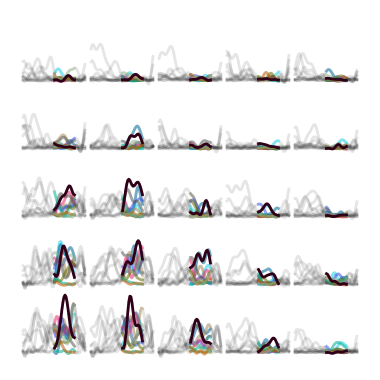

In [35]:
plot_resp_per_position(full_df, type_to_nid, neuron_id=example_neuron_id, 
                       sorting_idx=sorting_idx,
                      opt_slice=slice(30, 50), time_line_rec=np.linspace(0, 2, 60), 
                       fig_kwargs = dict(nrows=5, ncols= 5, figsize=(2, 2), sharey=True),
                      gridspec_kw=dict(wspace=0, hspace=0),
                      col_key = "resp_per_loc", 
                       alphas= np.concatenate([[.5 for i in range(10)], [1]]),
                       example_types=np.asarray(list(type_to_nid.keys())),
                       linewidth=1);

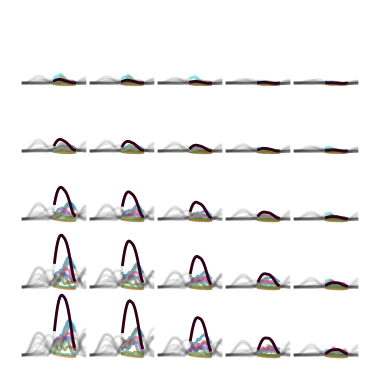

In [36]:
plot_resp_per_position(full_df, type_to_nid, neuron_id=example_neuron_id, 
                       sorting_idx=sorting_idx,
                      opt_slice=slice(30, 50), time_line_rec=np.linspace(0, 2, 60), 
                       fig_kwargs = dict(nrows=5, ncols= 5, figsize=(2, 2), sharey=True),
                      gridspec_kw=dict(wspace=0, hspace=0),
                      col_key = "model_resp_per_loc", 
                       alphas= np.concatenate([[.5 for i in range(10)], [1]]),
                       example_types=np.asarray(list(type_to_nid.keys())),
                       linewidth=1);

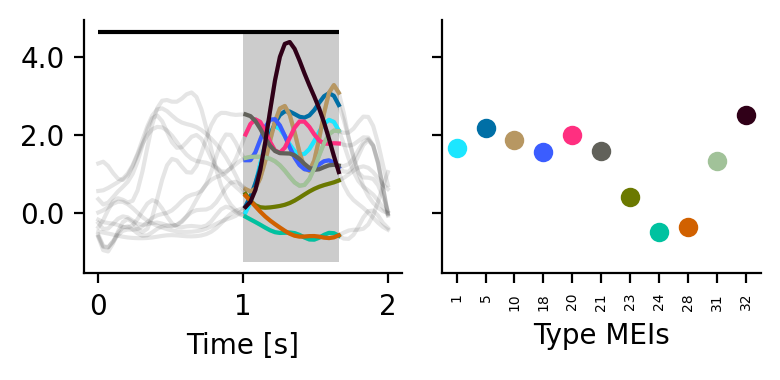

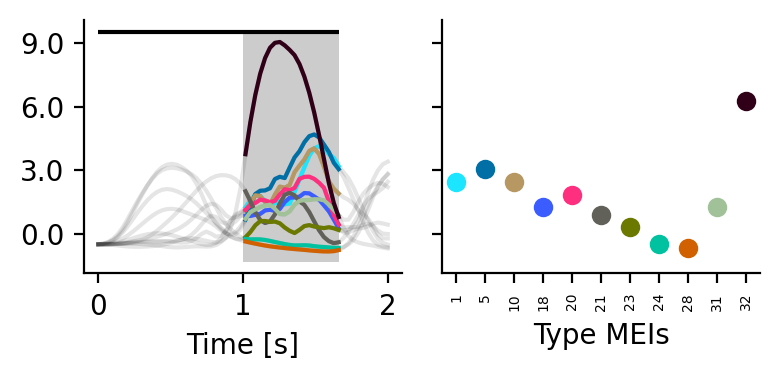

In [37]:
for m, col_key in zip([False, True],["resp_per_loc", "model_resp_per_loc"]):
    fig = plot_responses(time_line, opt_slice,
                   get_weighted_resp(full_df, example_neuron_id, col_key), 
                         ordered_type_to_nid,
                         aggregate_fun=np.mean,
                   fig_kwargs=dict(nrows=1, ncols=2, figsize=(4, 2), sharey=True), 
                         is_model=m,
                   sorting_idx=sorting_idx, 
                         indicate_stim=True
                   );


### population plots

#### measured neural responses

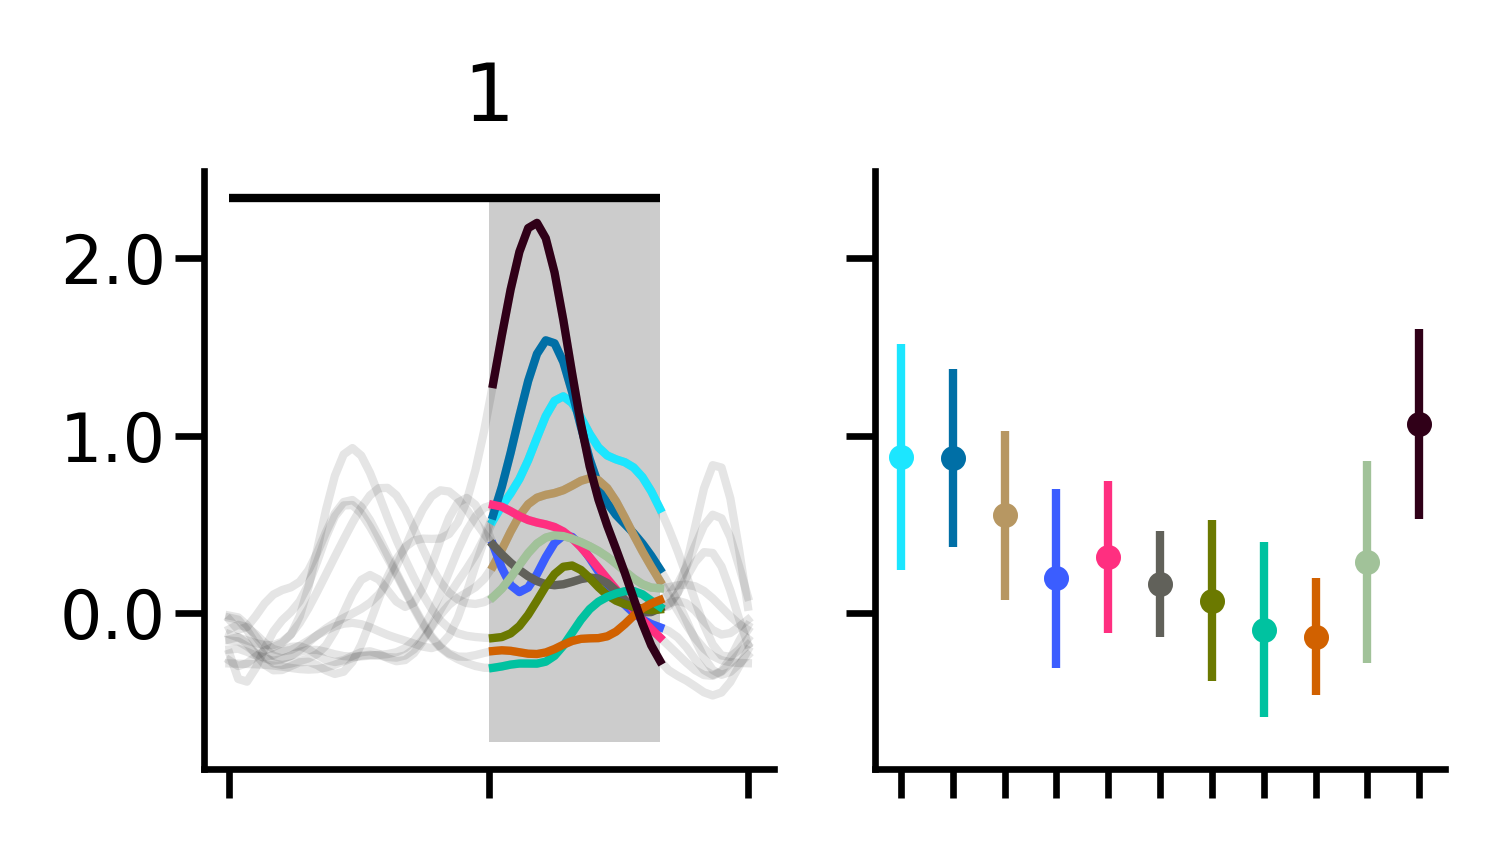

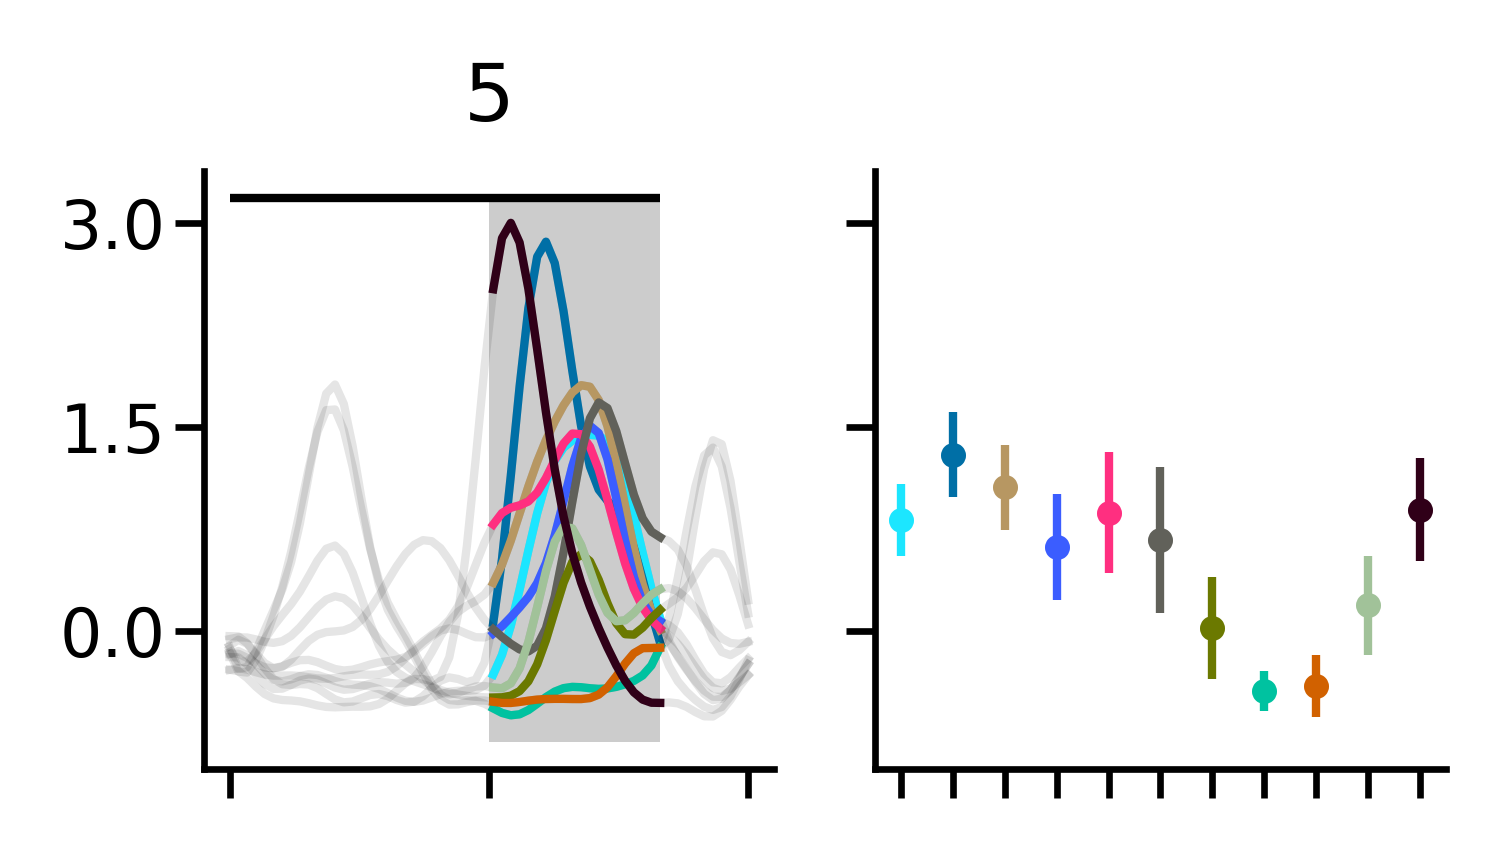

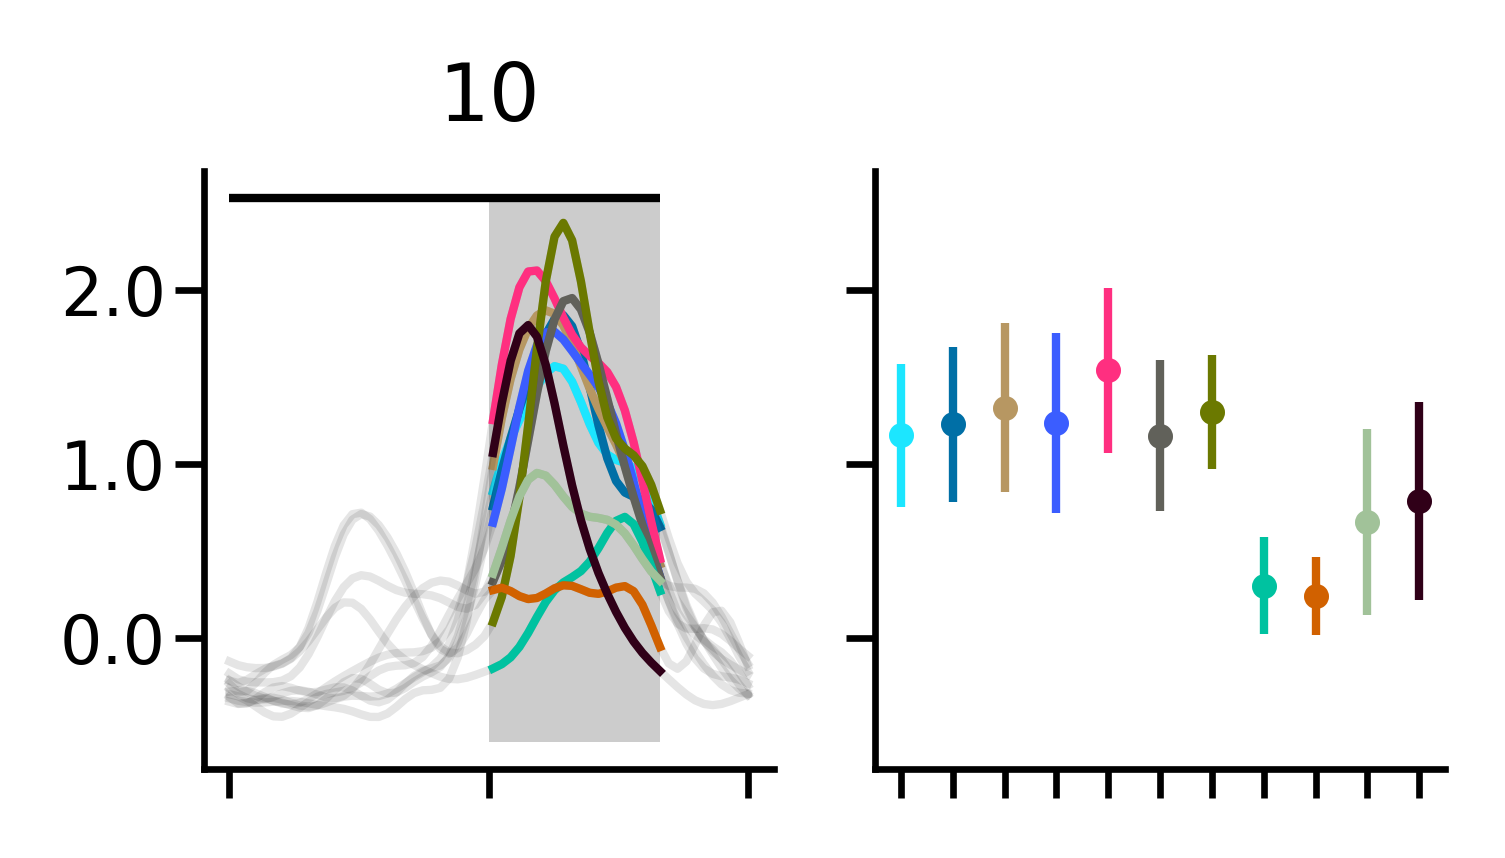

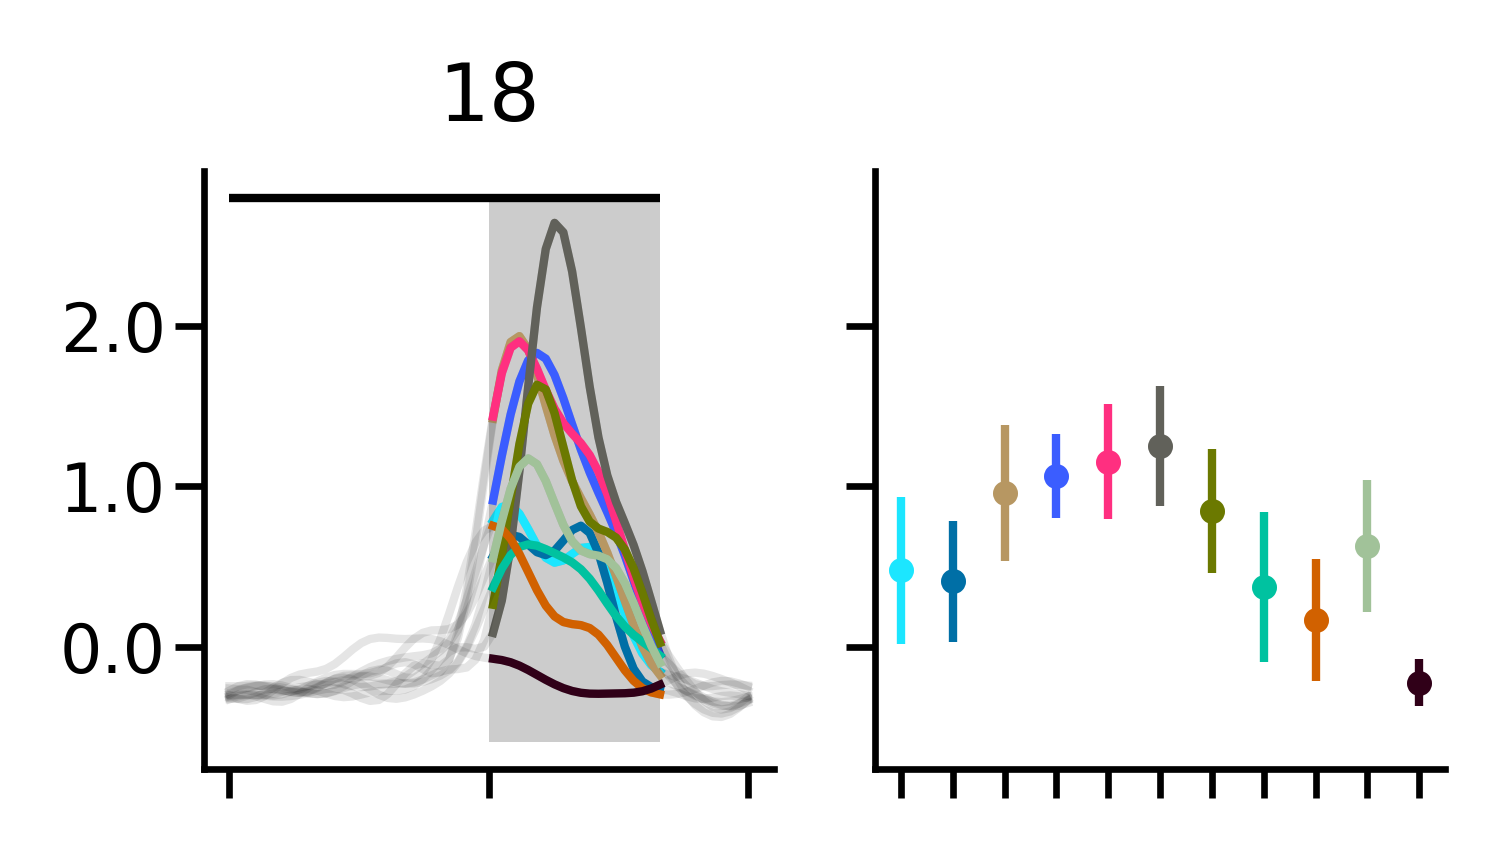

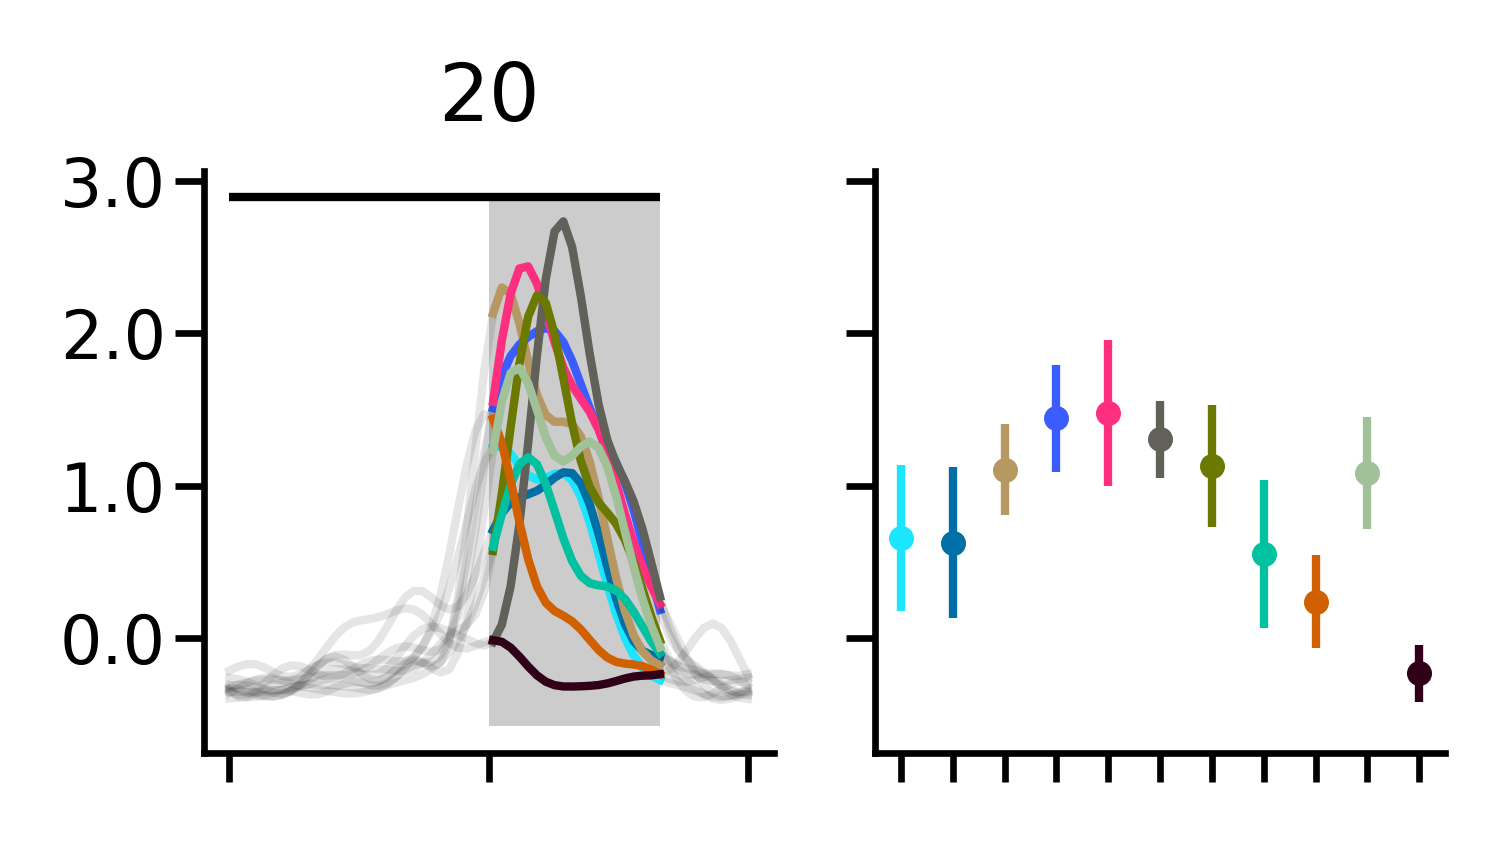

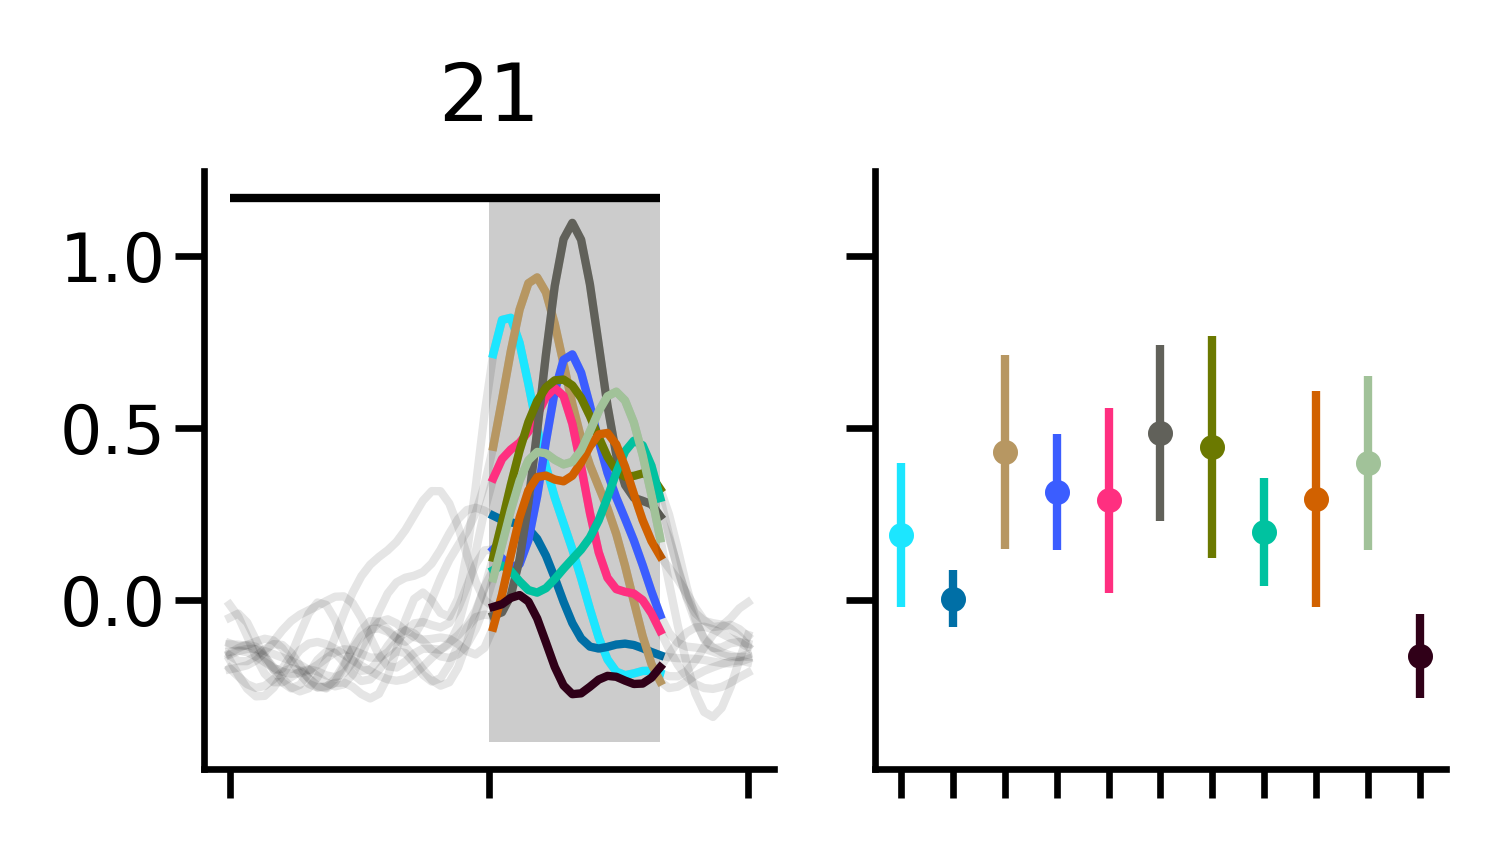

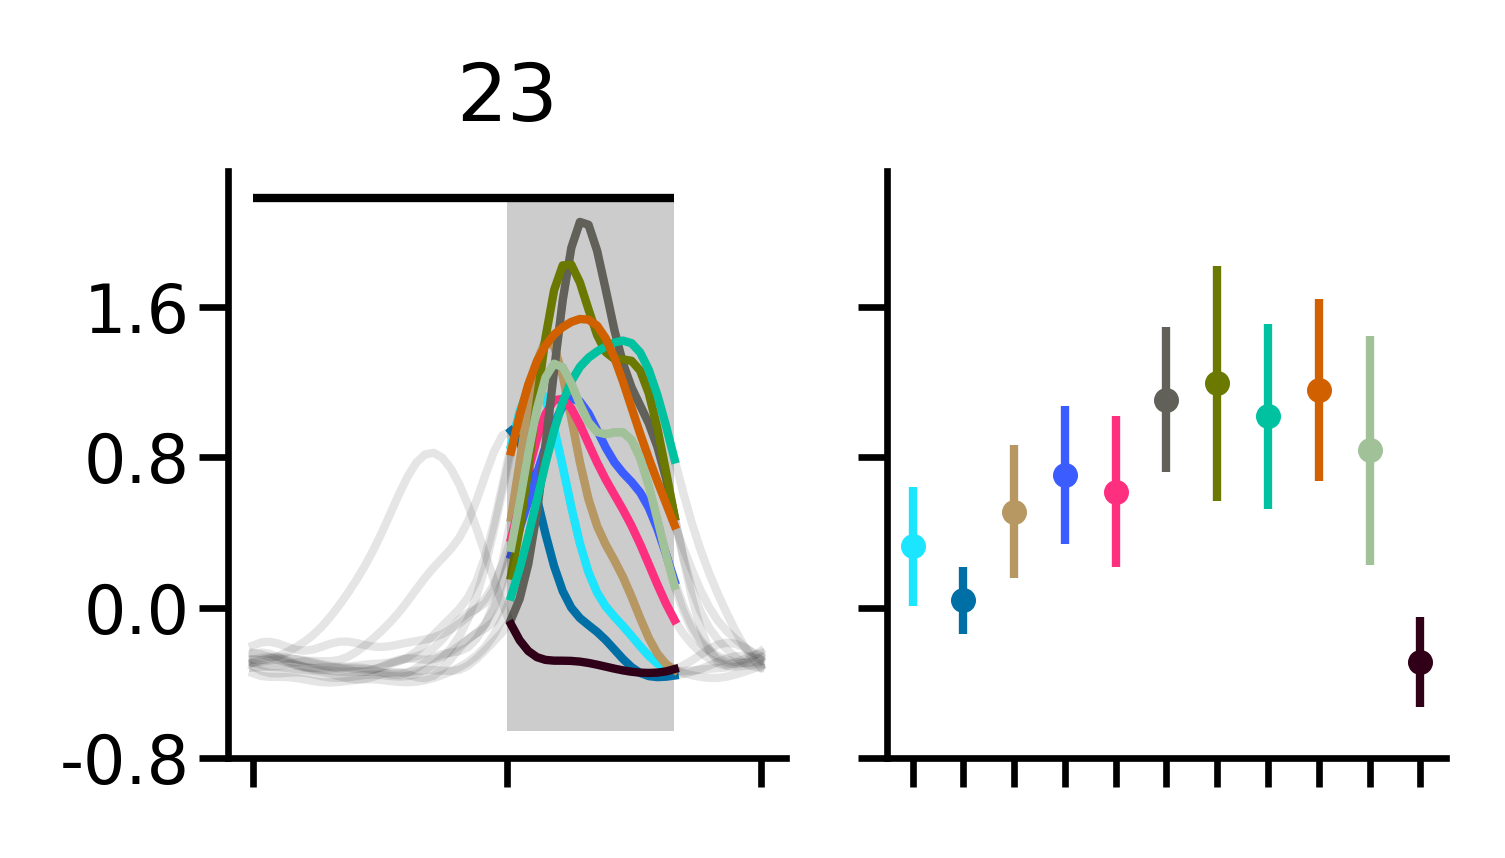

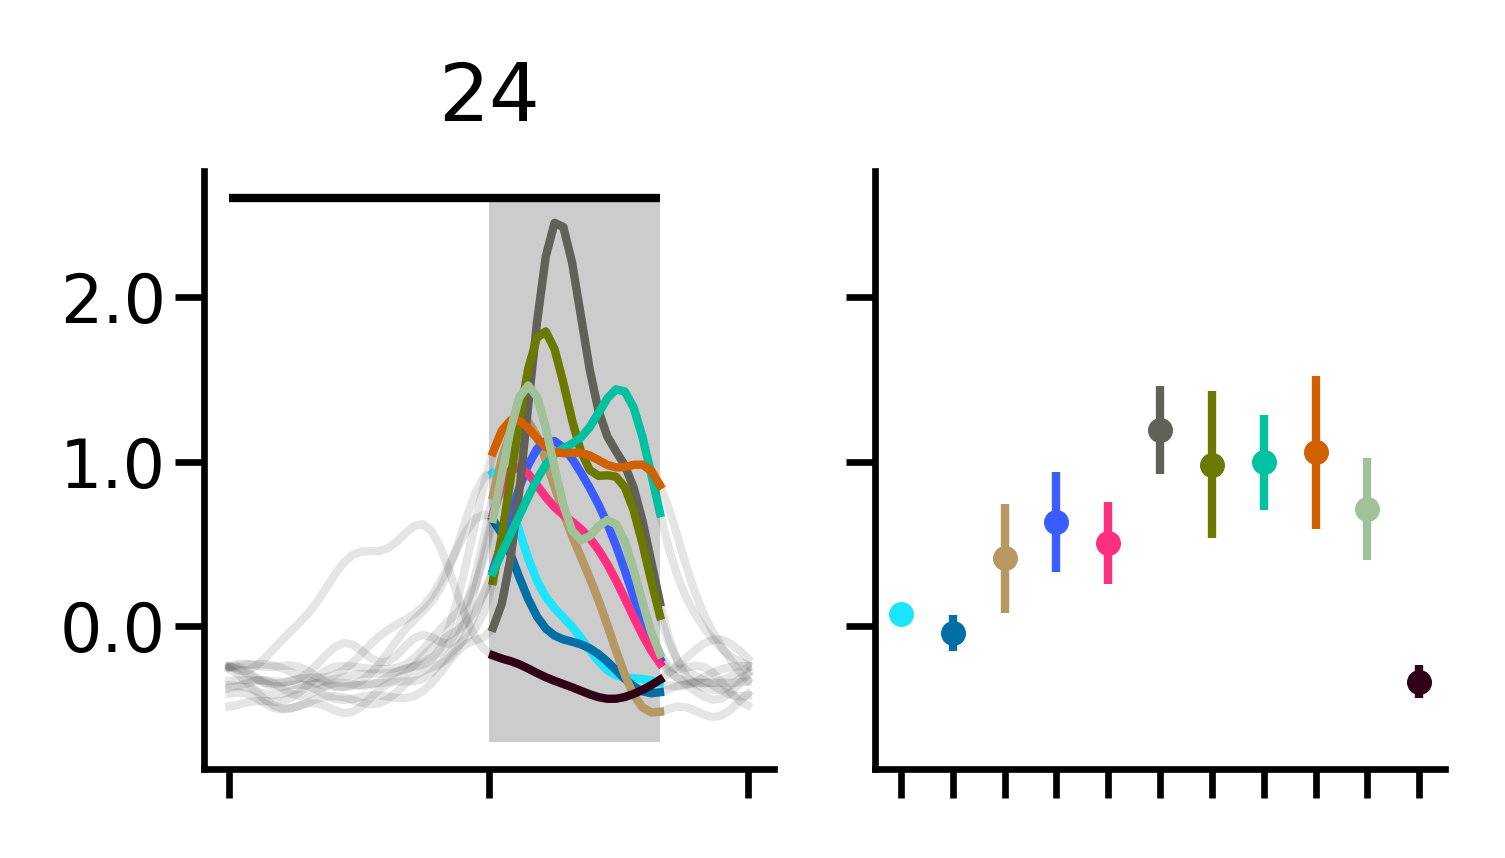

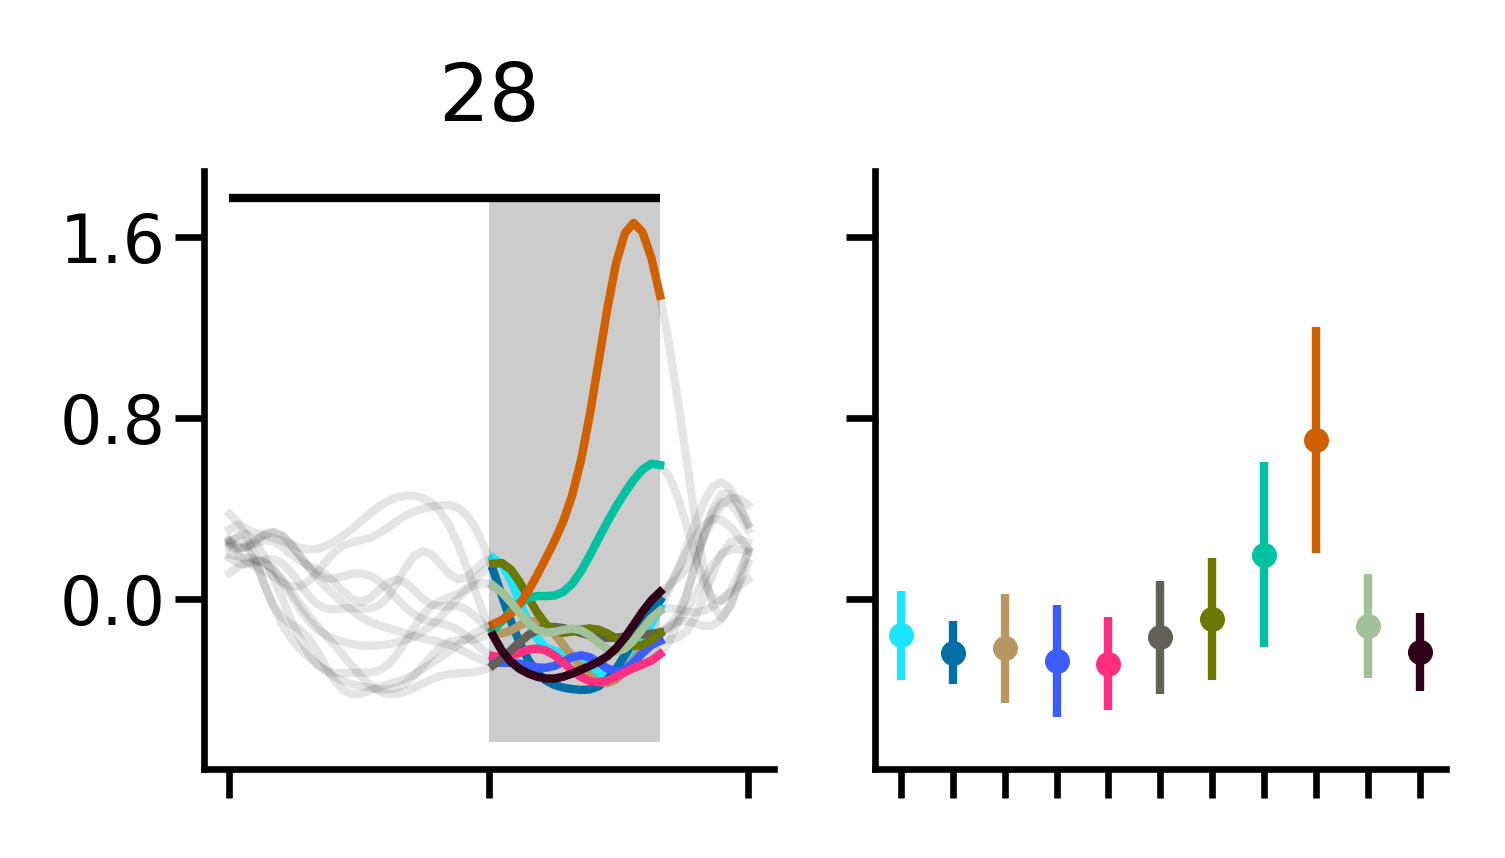

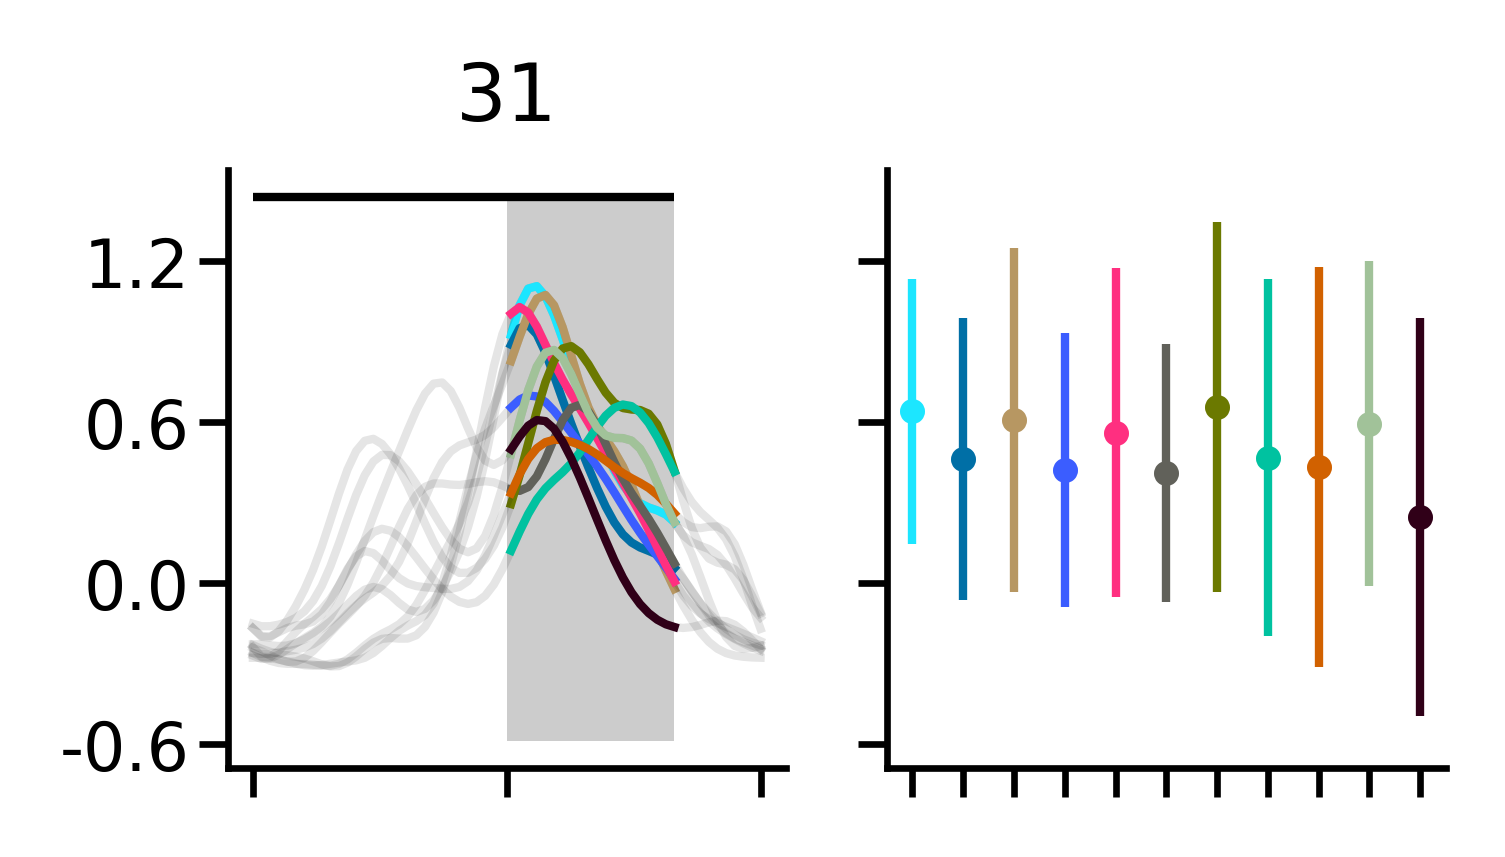

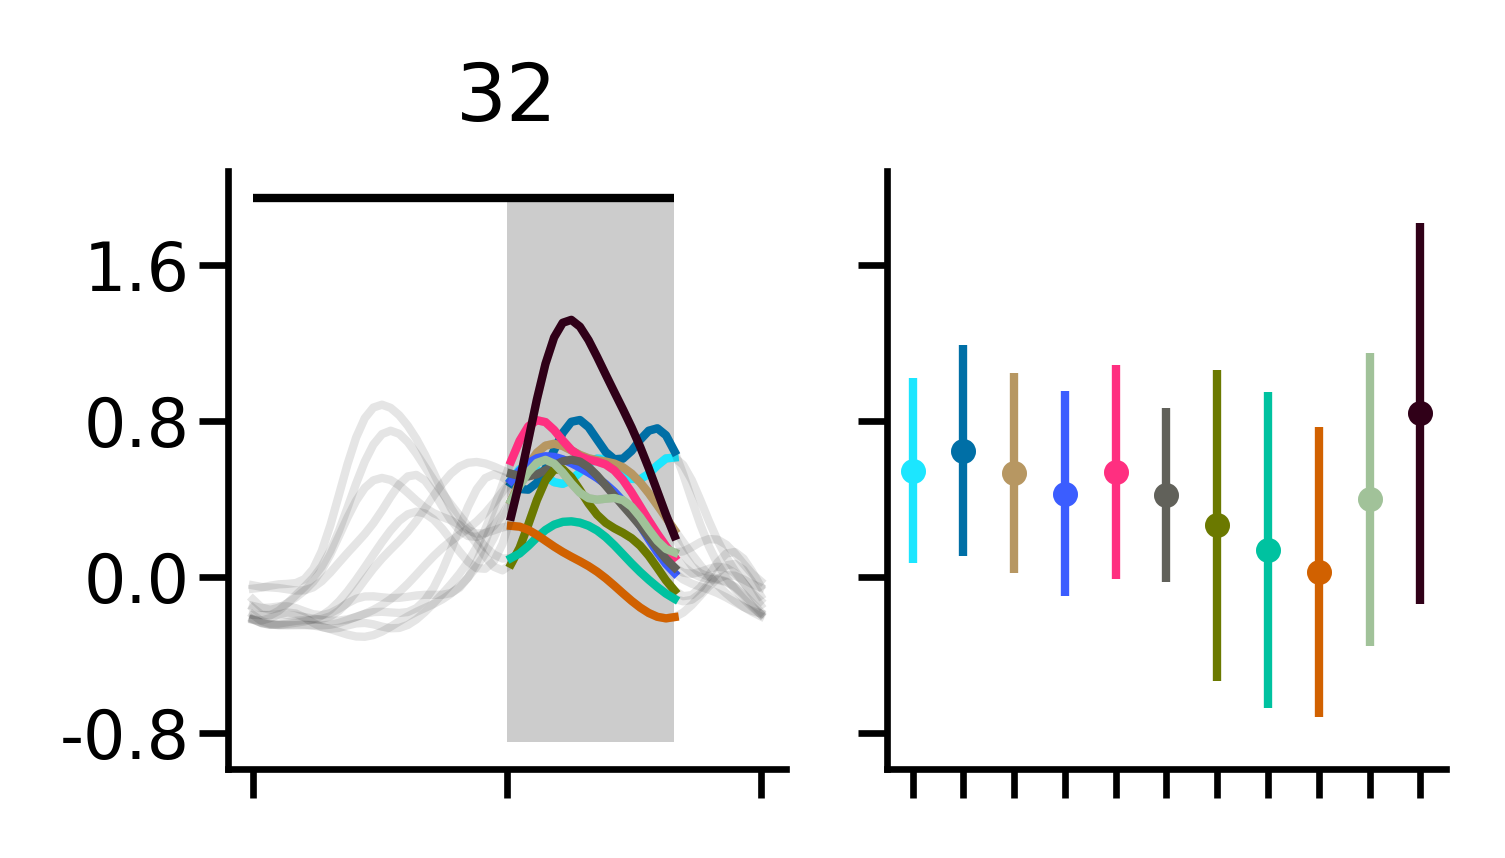

In [38]:
with mpl.rc_context(rc_dict_resp):
    for t in example_types:
        fig = plot_responses(time_line, opt_slice,
                       weighted_resp_by_type[t], ordered_type_to_nid,aggregate_fun=np.mean,
                       #alphas=[.3, .3, .3, .3, .3, .3, 1, 1, 1, .3, .3, .3],
                       fig_kwargs=dict(nrows=1, ncols=2, 
                                       figsize=(2.55, 1.285),#(3, 1.5), 
                                       sharey=True),
                             sorting_idx=sorting_idx, xlabels=False,
                             indicate_stim=True
                   );
        plt.title(t)

#### predicted neural responses

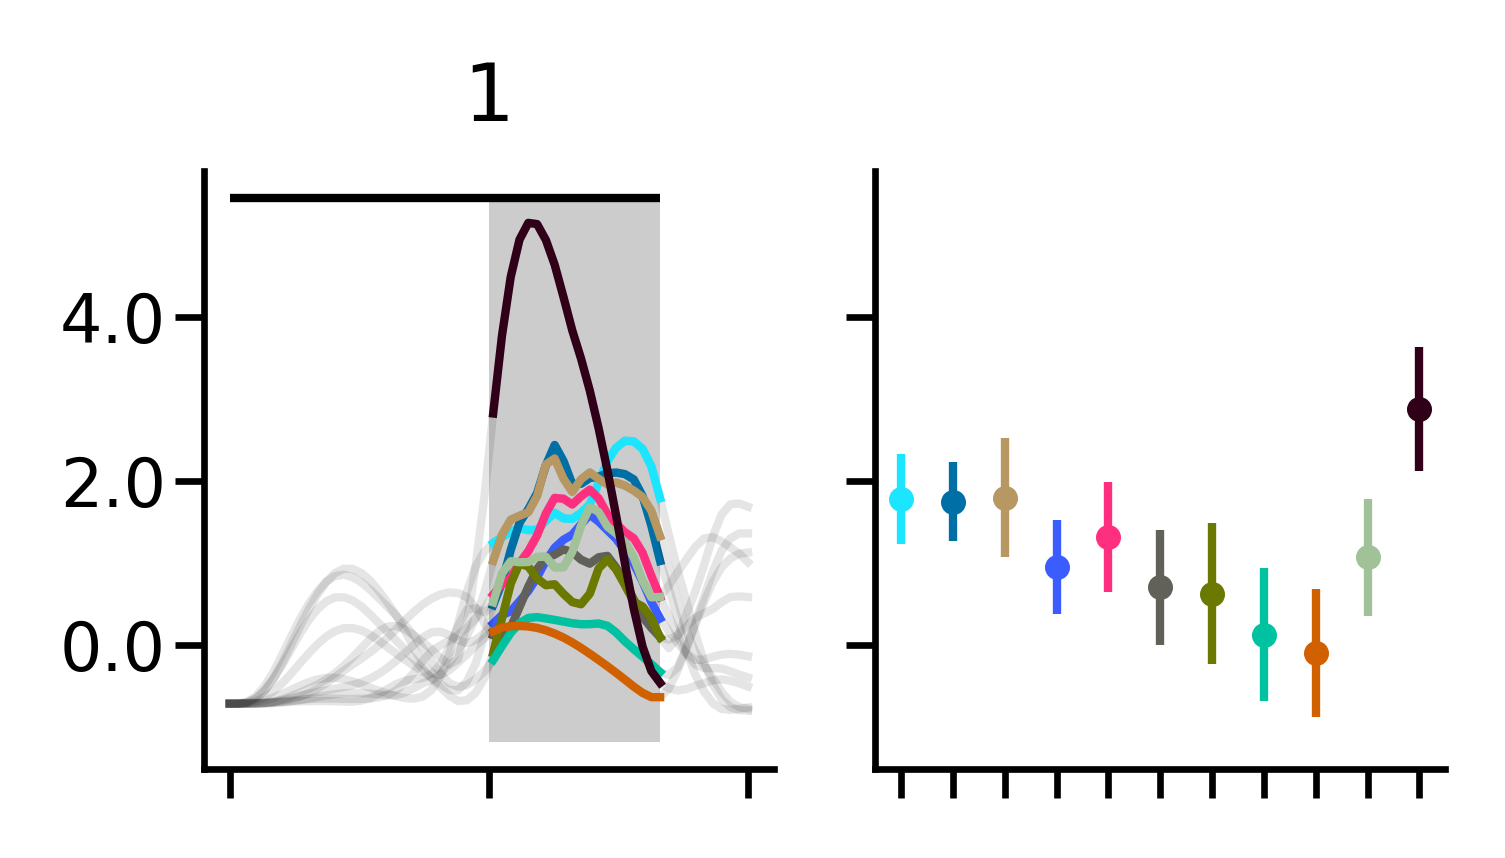

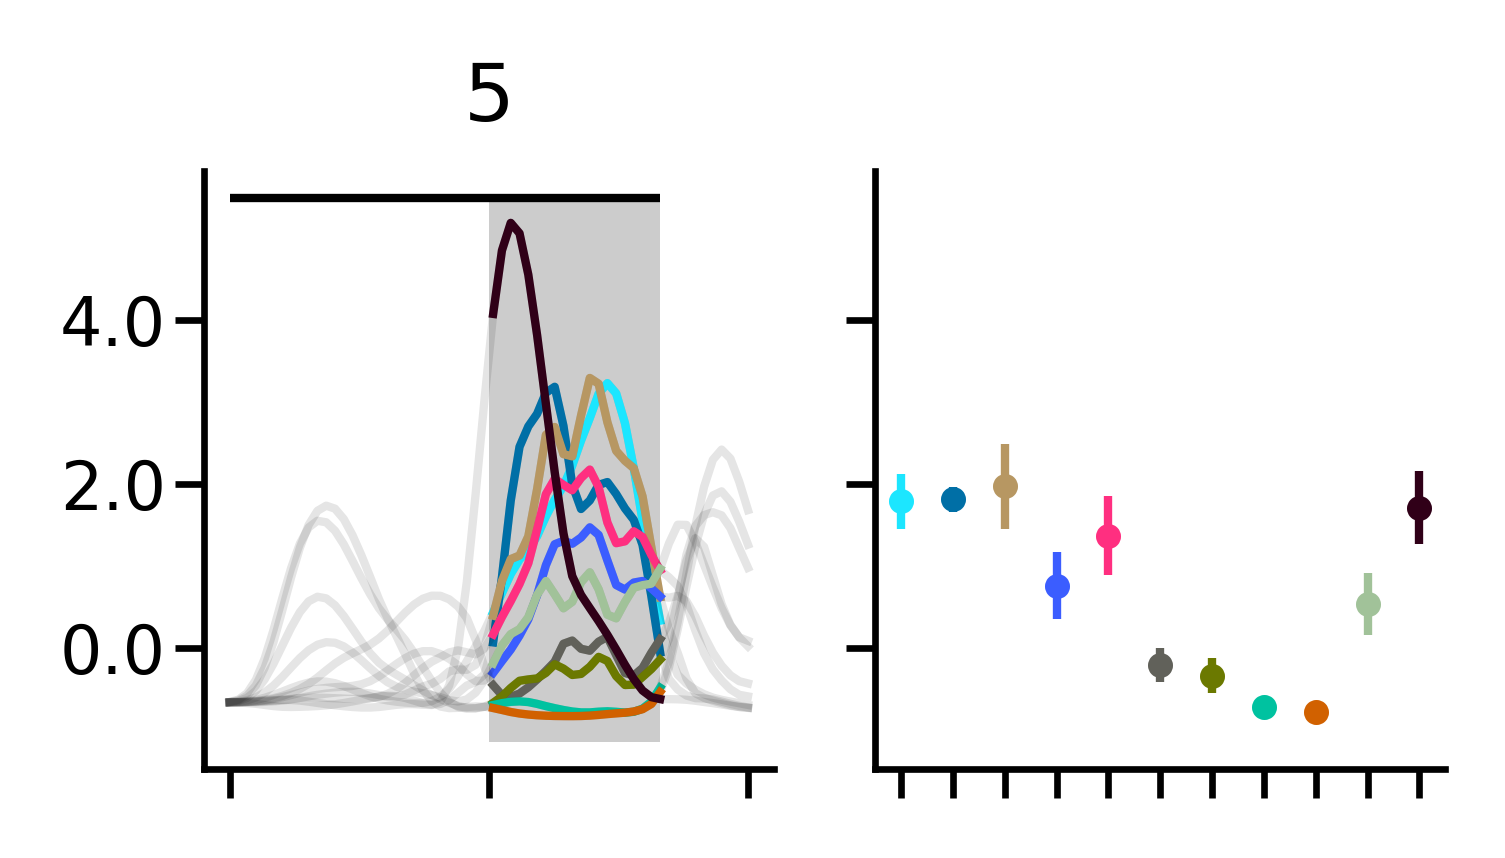

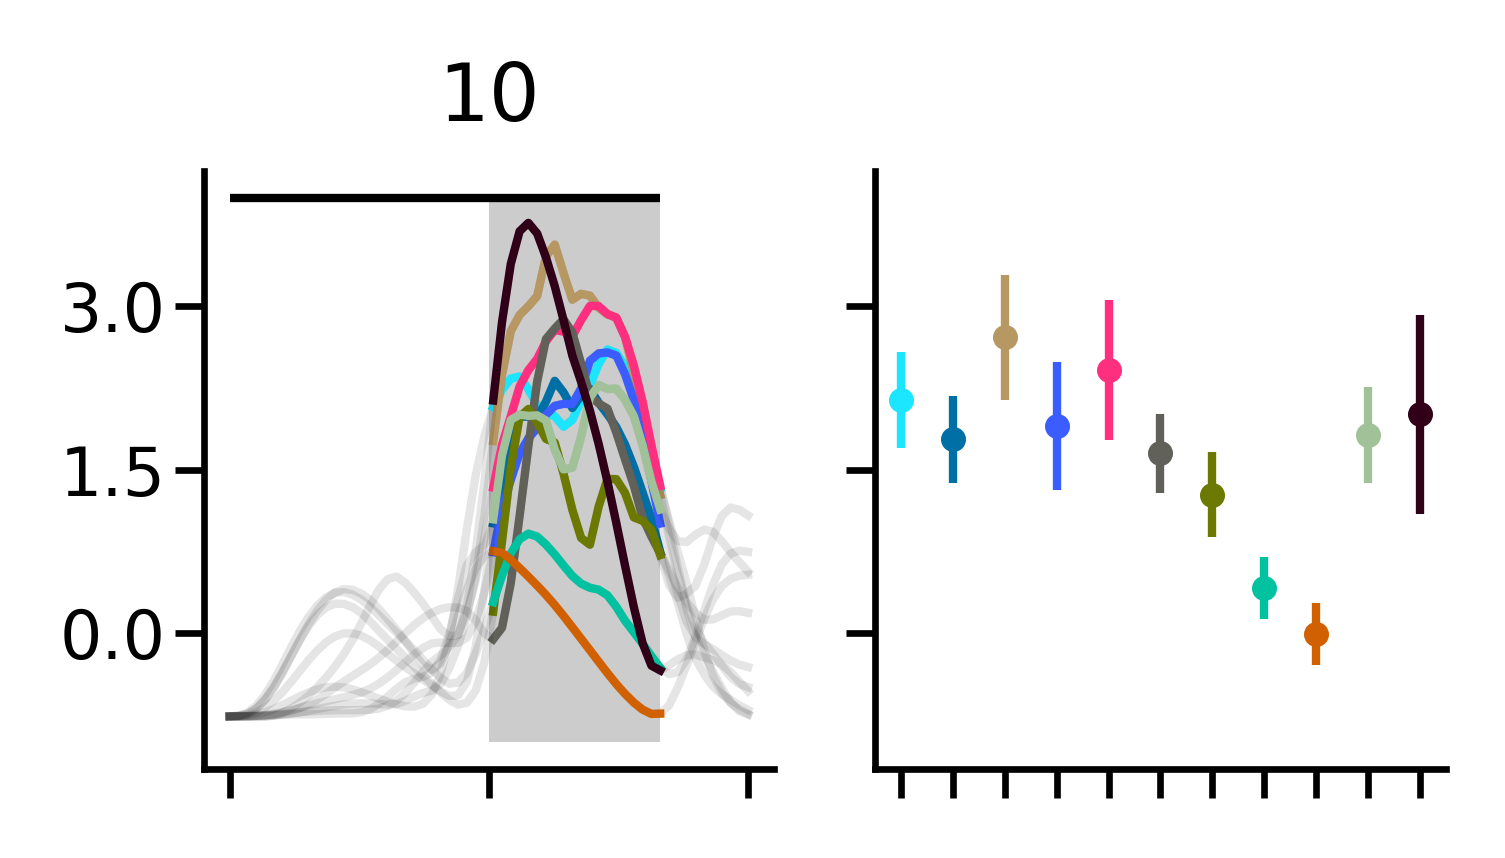

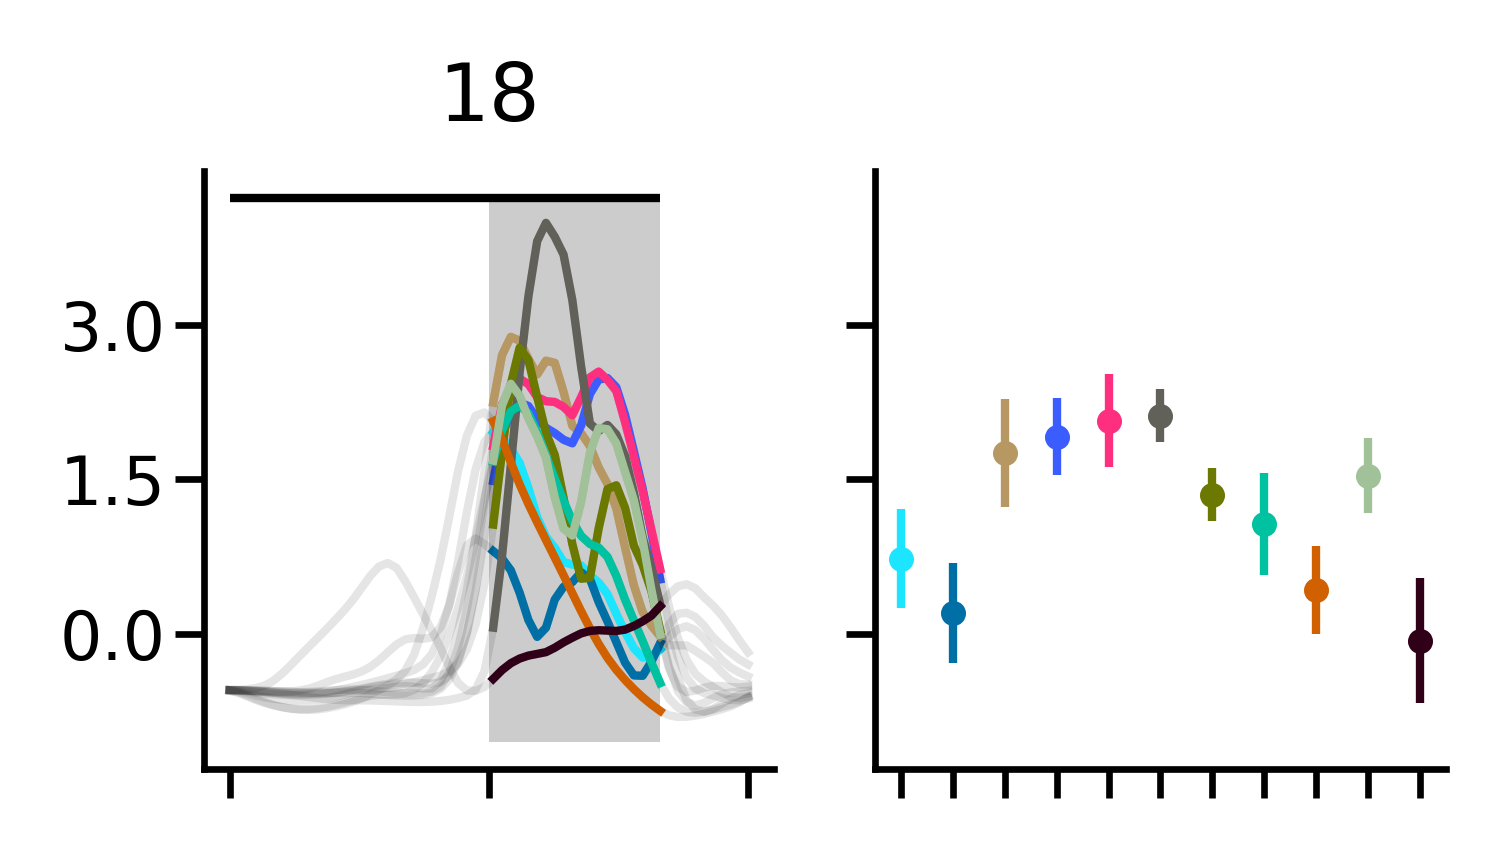

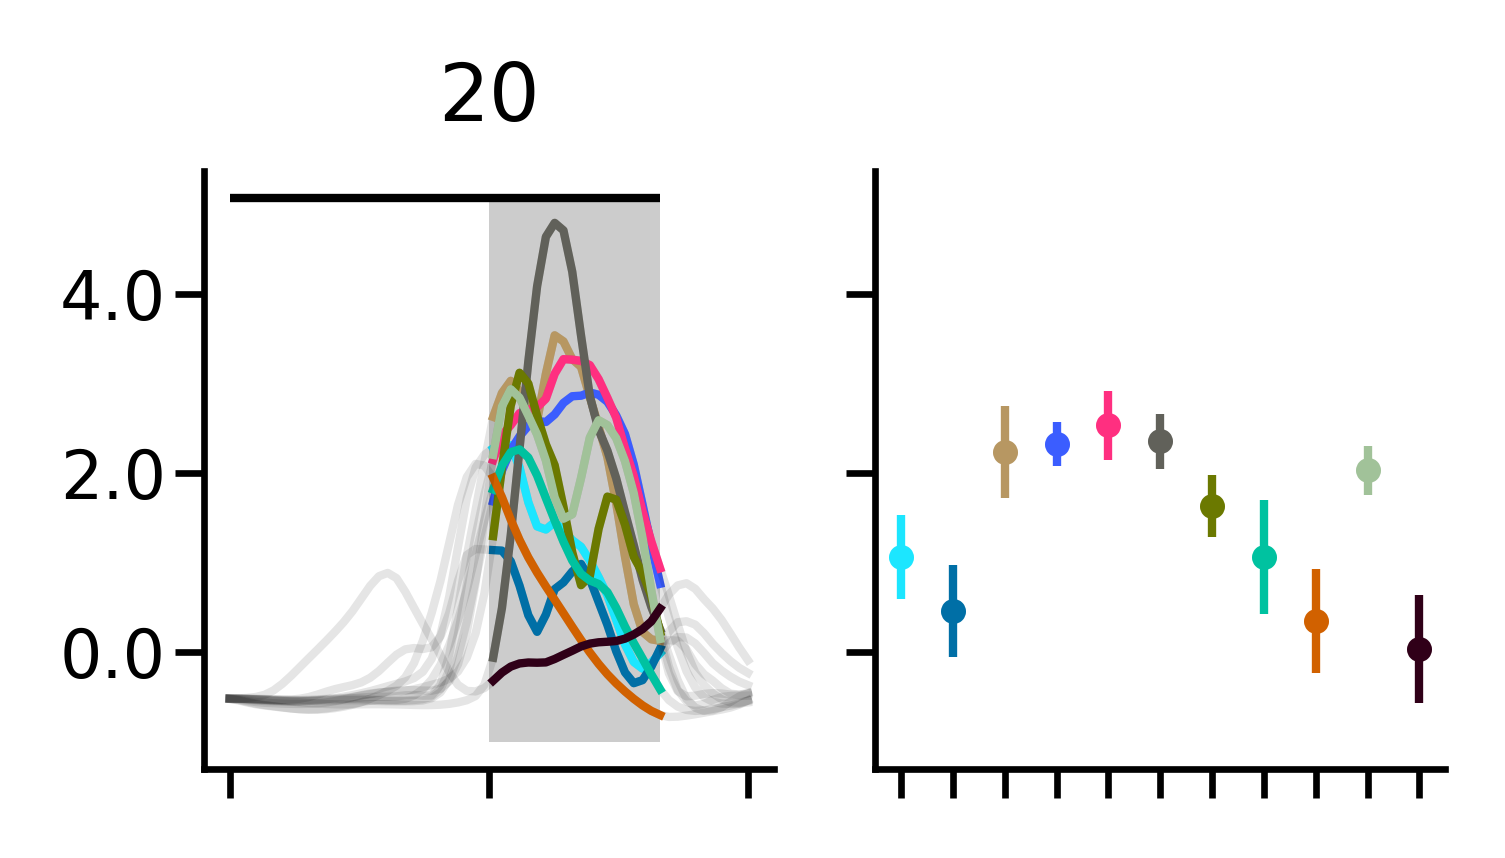

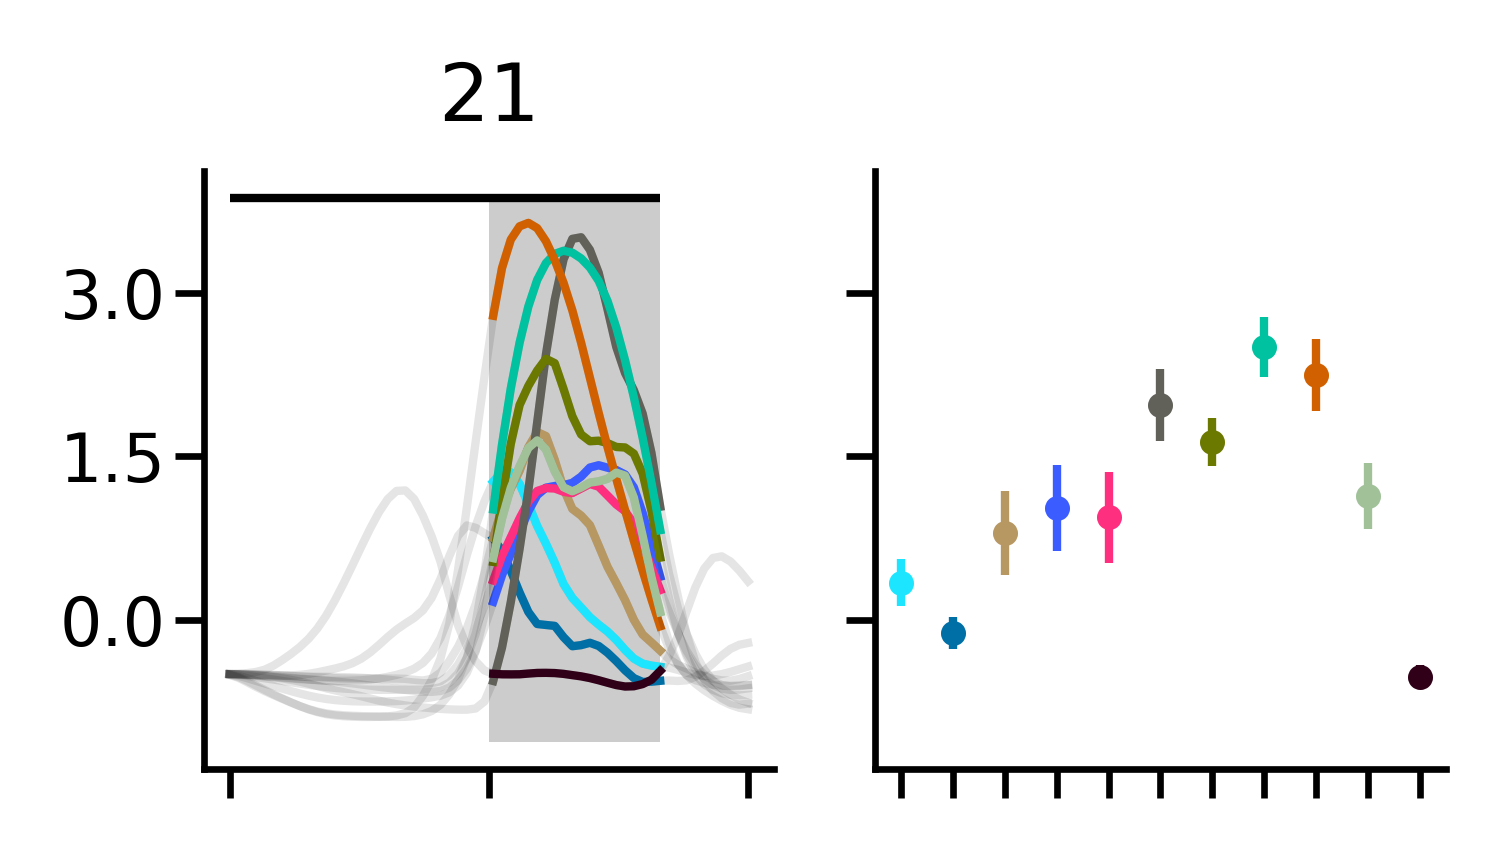

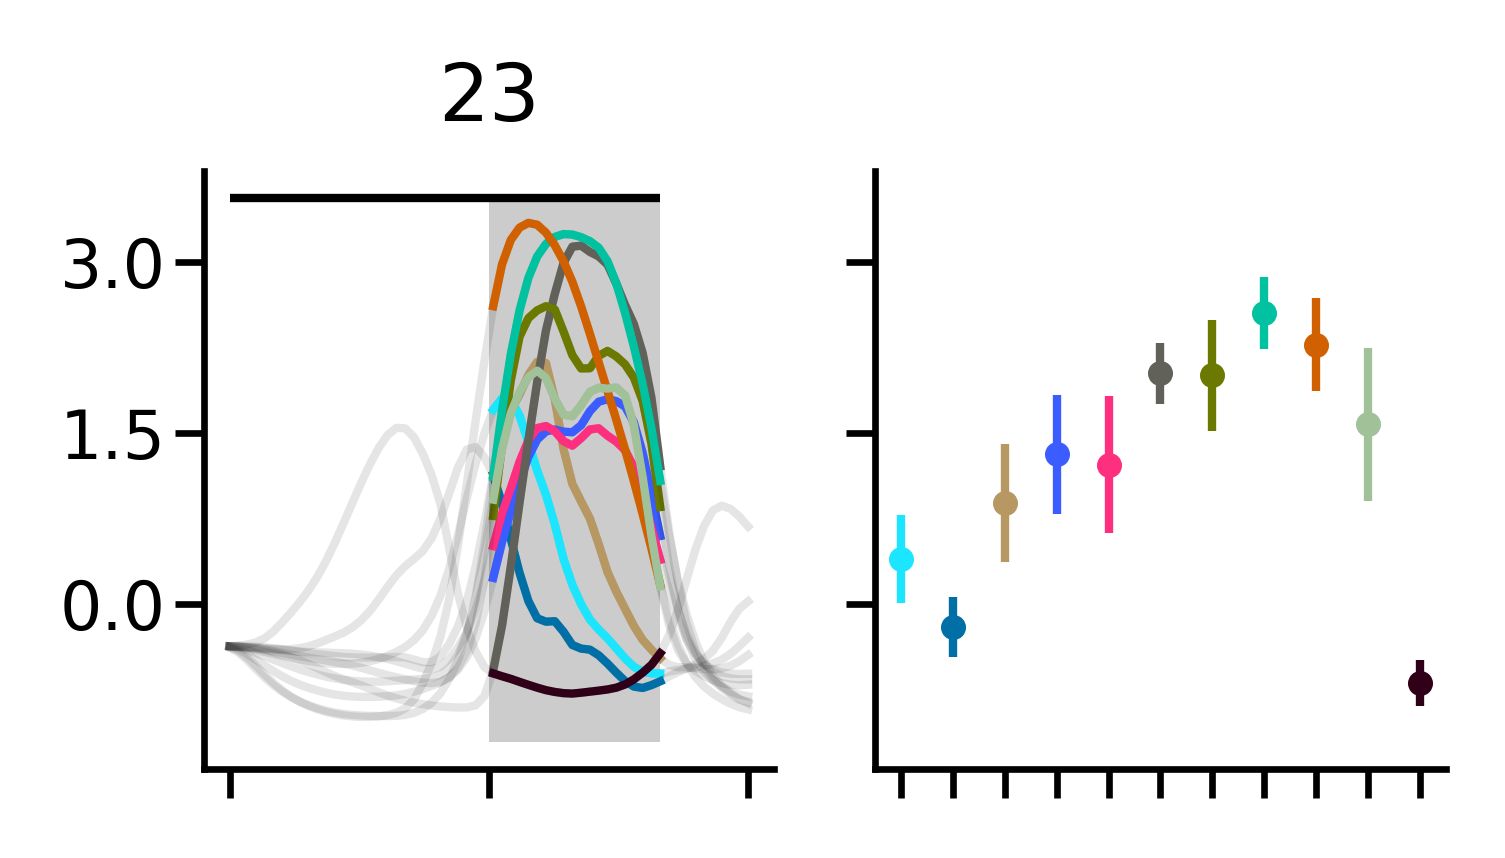

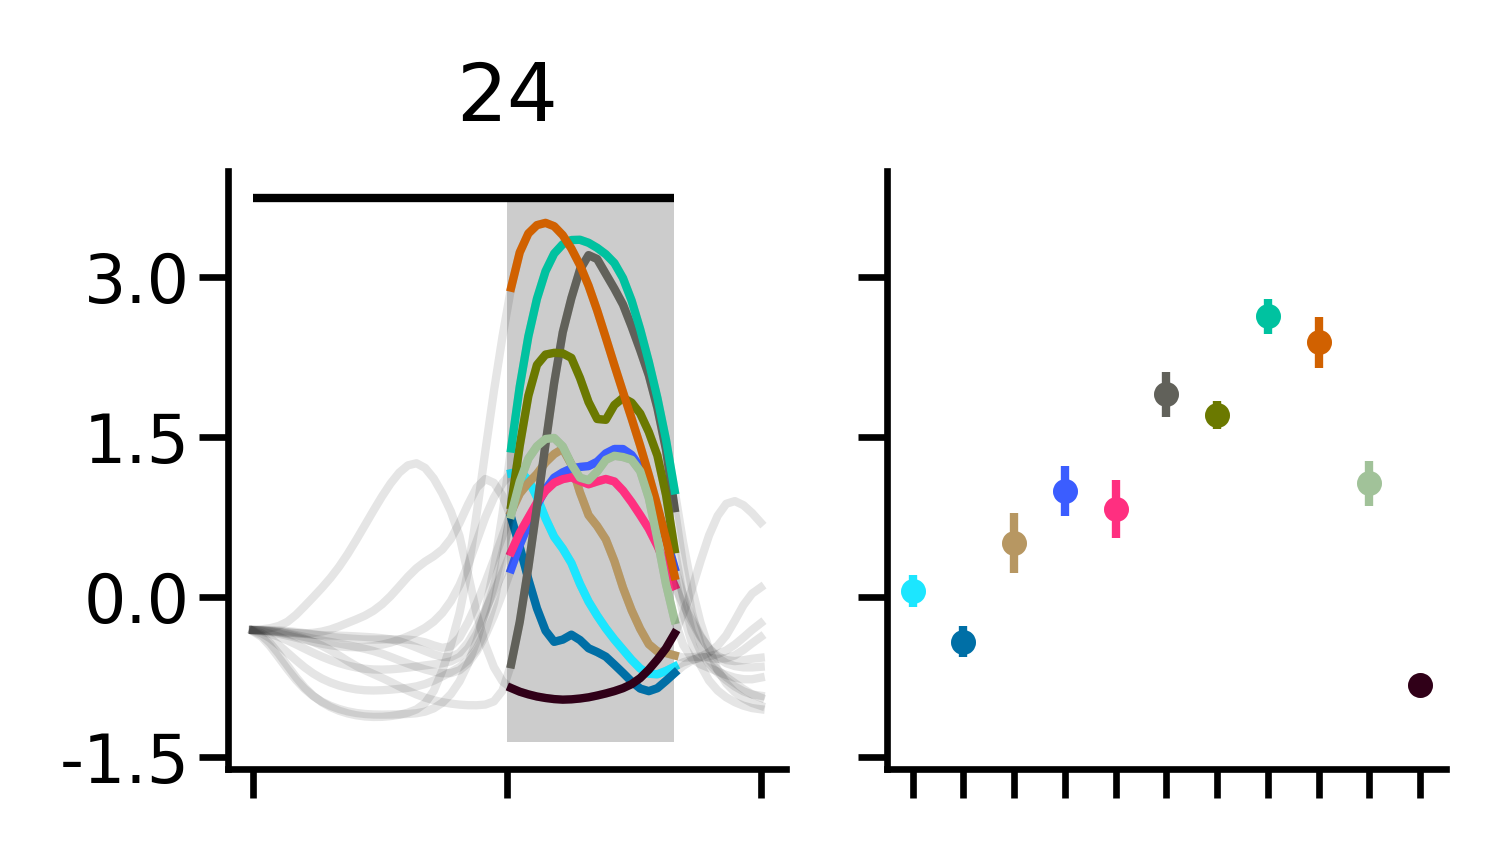

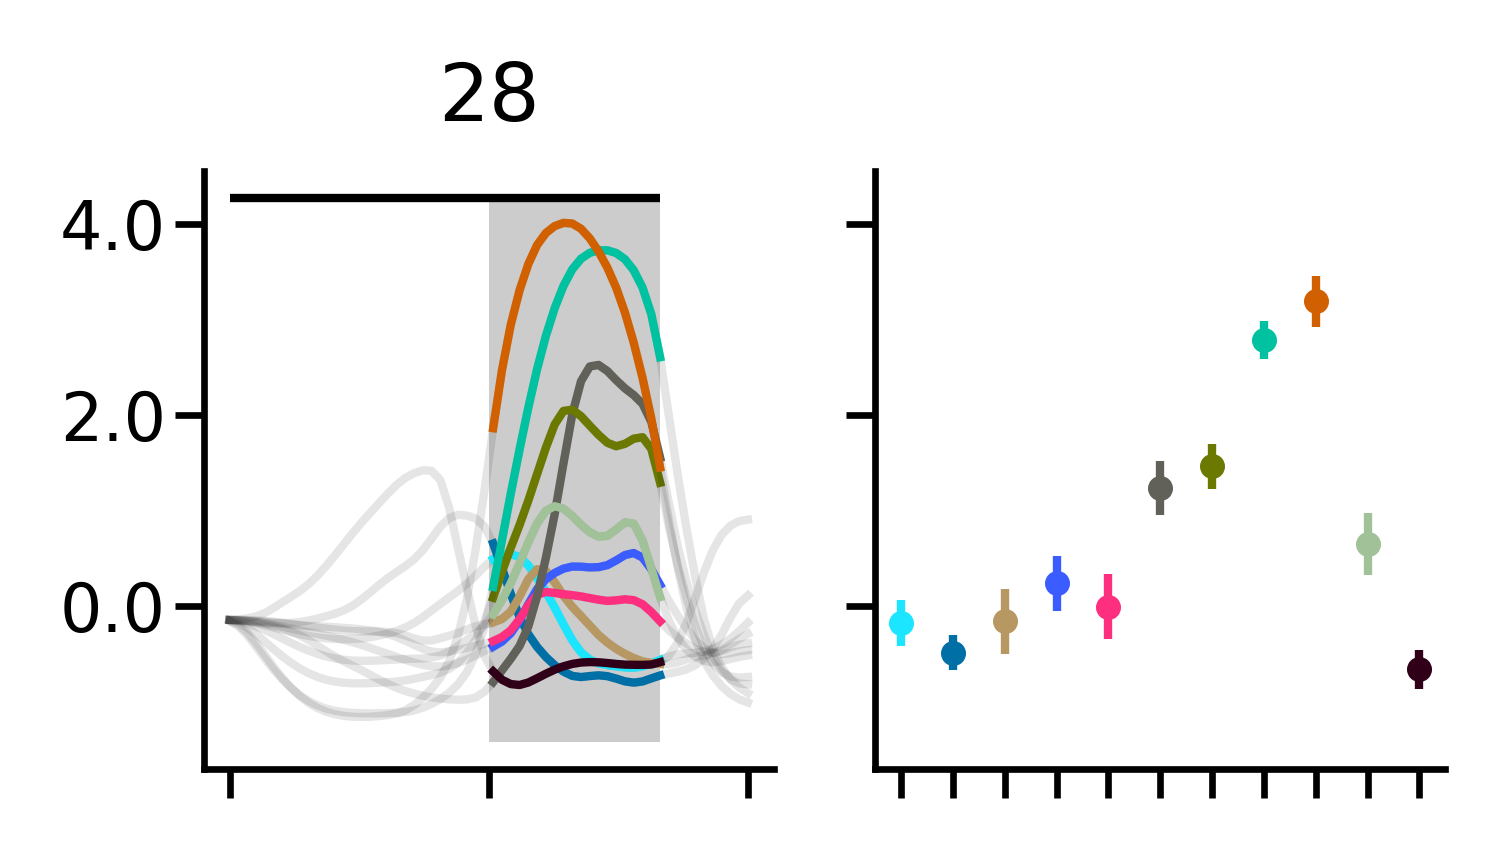

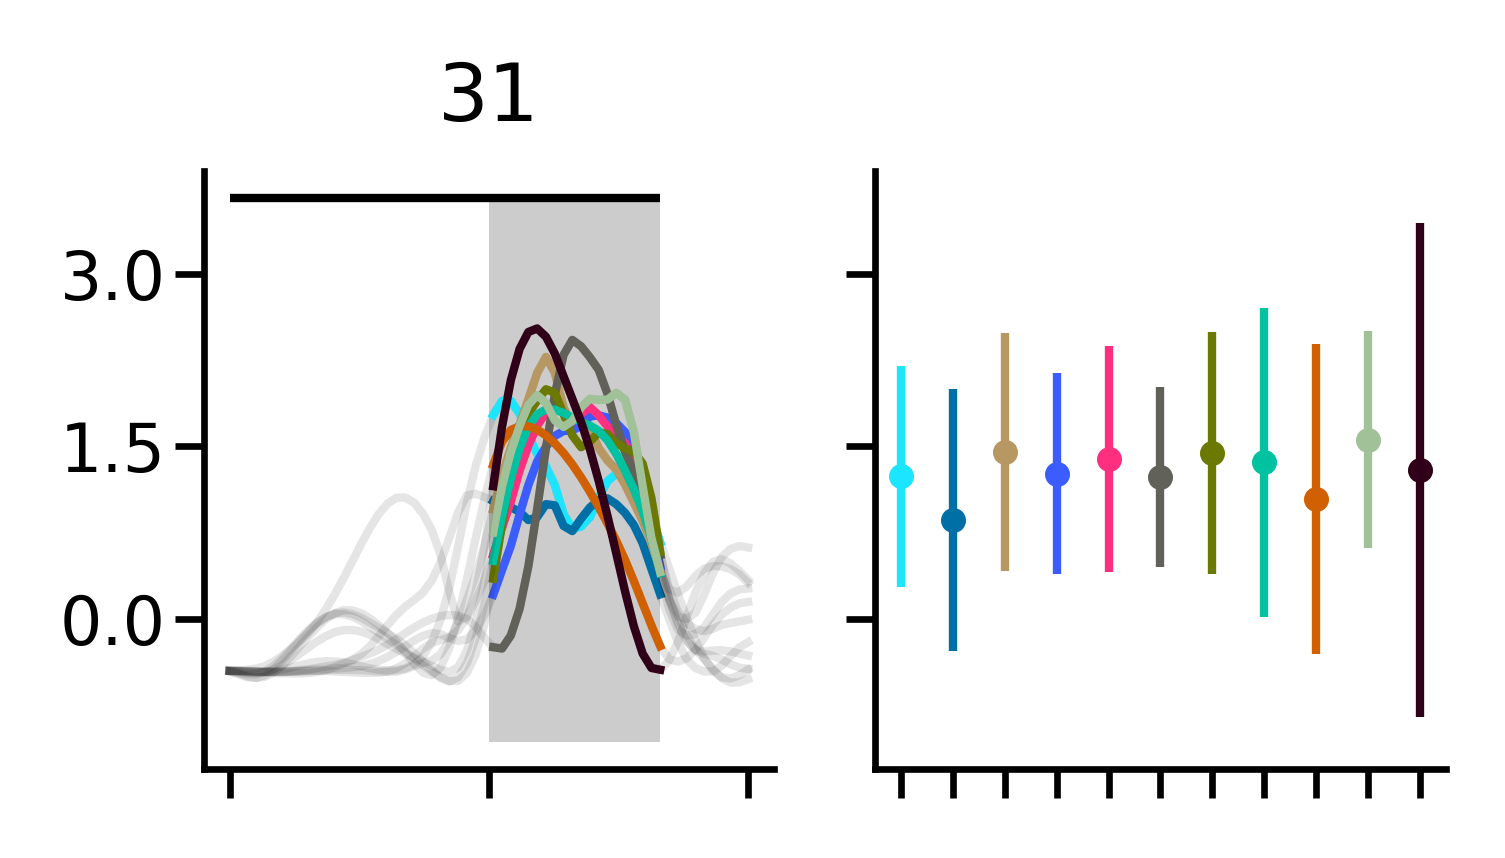

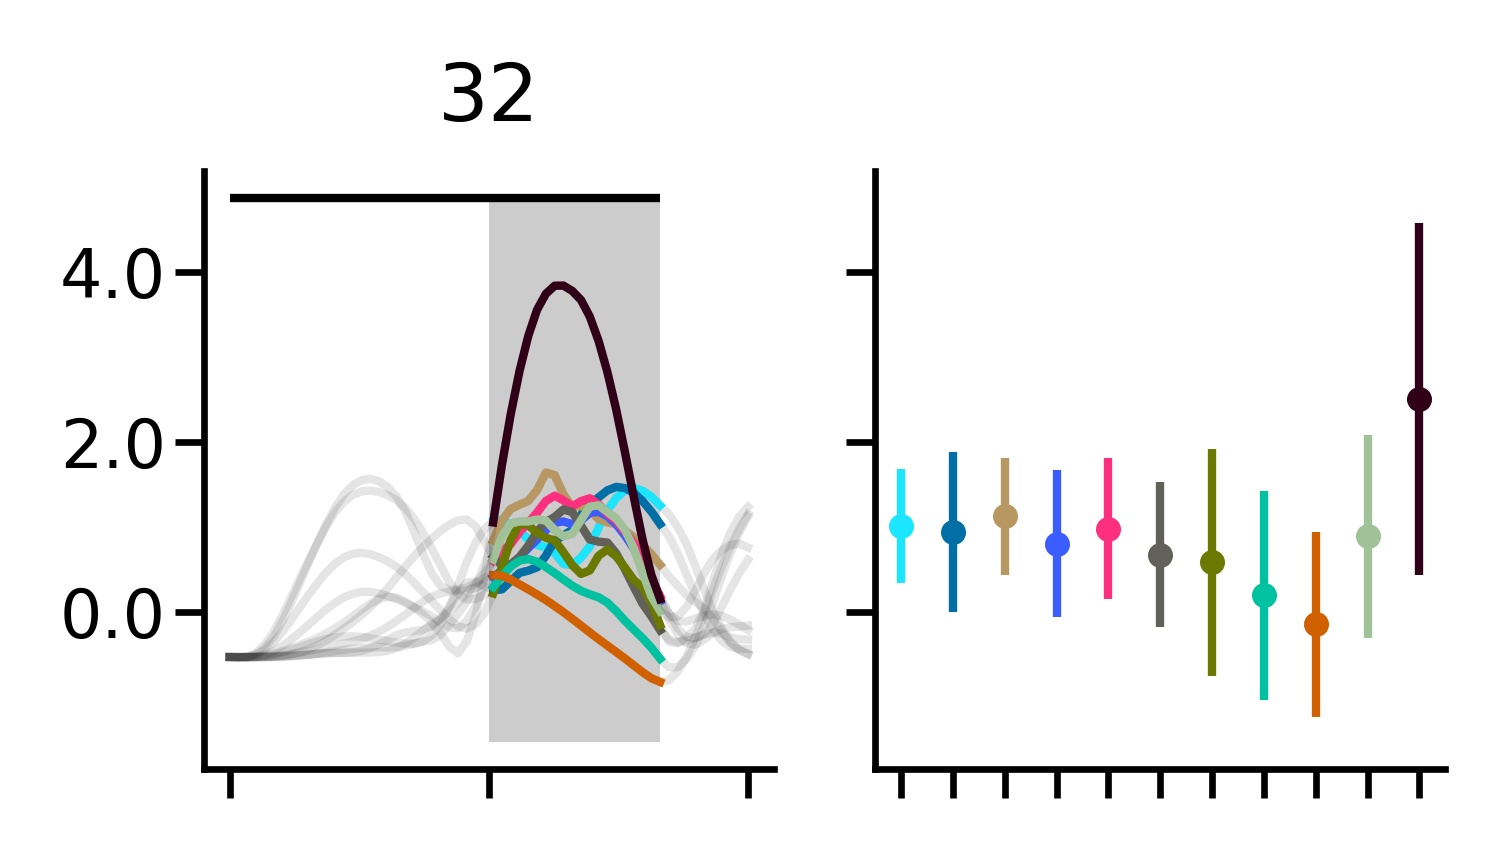

In [39]:
with mpl.rc_context(rc_dict_resp):
    for t in example_types:
        fig = plot_responses(time_line, opt_slice,
                       weighted_resp_by_type_mod[t], ordered_type_to_nid,aggregate_fun=np.mean,
                       #alphas=[.3, .3, .3, .3, .3, .3, 1, 1, 1, .3, .3, .3],
                       fig_kwargs=dict(nrows=1, ncols=2, 
                                       figsize=(2.55, 1.285),#(3, 1.5), 
                                       sharey=True),
                             sorting_idx=sorting_idx, xlabels=False,
                             indicate_stim=True
                   );
        plt.title(t)